In [1]:
#Main libraries
import os
import glob
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pandas as pd

#sklearn libraries
from skimage.feature import hog
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

#video settings 
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [20]:
#Importing test images
image_list = [] #for test images
car_list = [] #sample cars
random_list = [] #sample random stuff 

for filename in glob.glob('./test_images/*.jpg'): #assuming gif
    image_list.append(filename)

for filename in glob.glob('./sample_car/*.png'): 
    car_list.append(filename)
    
for filename in glob.glob('./sample_stuff/*.png'): 
    random_list.append(filename)

In [21]:
#Testing colorspaces
# Plot features
plt.rcParams["figure.figsize"] = [25,15]

def bin_spatial(img, color_space, size=(64, 64)):
    # Convert image to new color space (if specified)
    img = cv2.resize(img, (32, 32))
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)  
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, (32,32)).ravel() 
    # Return the feature vector
    return features
    
colorspaces = ['RGB',' HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

fig = plt.figure()
for i in range(len(car_list)): 
    image = car_list[i]
    for j in range(len(colorspaces)): 
        feature_vec = bin_spatial(image, color_space=colorspaces[j], size=(64, 64))
        fig.add_subplot(len(car_list), len(colorspaces), i*len(colorspaces) + j + 1)
        plt.plot(feature_vec)

# Plot features
fig.show()

TypeError: src is not a numpy array, neither a scalar

## HOG Features Implementation

In [82]:
#Udacity lesson code 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):
                         
    # TODO: Complete the function body and returns
    pix_per_cell = 8
    cell_per_block = 2
    orient = 9

    hog_features, hog_image = hog(img, orientations=orient,
                              pixels_per_cell=(pix_per_cell, pix_per_cell), 
                              cells_per_block=(cell_per_block, cell_per_block), 
                              visualise=True, feature_vector=feature_vec,
                              block_norm="L2-Hys")
                              
    
    return hog_features, hog_image

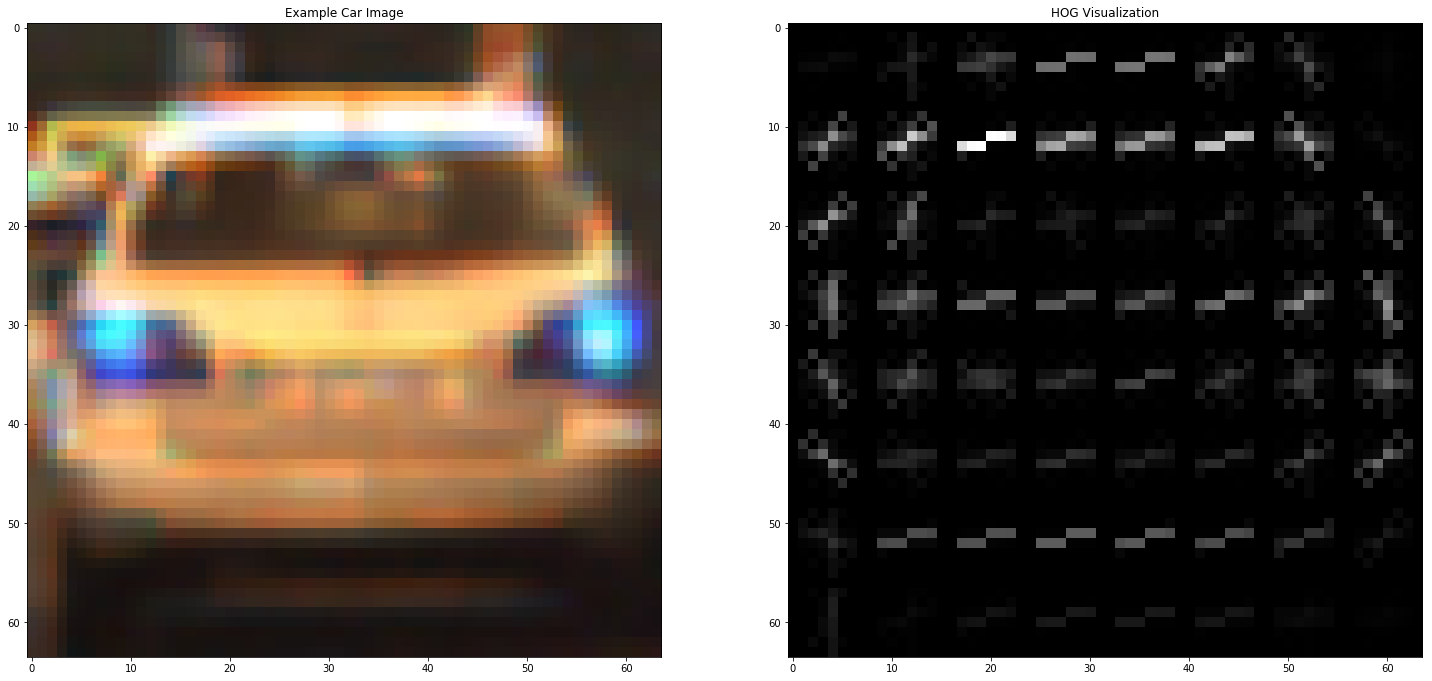

In [6]:

# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_list))
# Read in the image
image = car_list[ind]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

## Feature Extraction

In [ ]:
#original Udacity lesson extract_features code
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

In [161]:
#Udacity lesson code
# Modified extract function code since first part of code has already read inmage 
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs: 
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        #spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        #hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        #Get HOG features
        hog_features = get_hog_features(feature_image, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True, channel='ALL')
        hog_features = np.ravel(hog_features)
        # Append the new feature vector to the features list        
        #features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        features.append(hog_features)
    # Return list of feature vectors
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

#Udacity lesson code 
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, 
                     feature_vec=True, channel=0):
                         
    # TODO: Complete the function body and returns
#     pix_per_cell = 8
#     cell_per_block = 2
#     orient = 9

    if(channel != 'ALL'): 
        hog_features = hog(img[:,:,channel], orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=False, feature_vector=feature_vec,
                                  block_norm="L2-Hys")
    else: 
        hog_features = []
        for i in range(img.shape[2]): 
                hog_features_loc = hog(img[:,:,i], orientations=orient,
                              pixels_per_cell=(pix_per_cell, pix_per_cell), 
                              cells_per_block=(cell_per_block, cell_per_block), 
                              visualise=False, feature_vector=feature_vec,
                              block_norm="L2-Hys")
                hog_features.append(hog_features_loc)
        hog_features = np.ravel(hog_features)
    
    return hog_features


In [102]:
#Udacity lesson code
# Modified extract function code since first part of code has already read inmage 
# Have this function call bin_spatial() and color_hist()
def single_img_features(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    else: feature_image = np.copy(image)      
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    #Get HOG features
    hog_features = get_hog_features(feature_image, orient= 9, 
                    pix_per_cell= 8, cell_per_block= 2, 
                    vis=True, feature_vec=True, channel='ALL')
    hog_features = np.ravel(hog_features)
    # Append the new feature vector to the features list        
    features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features


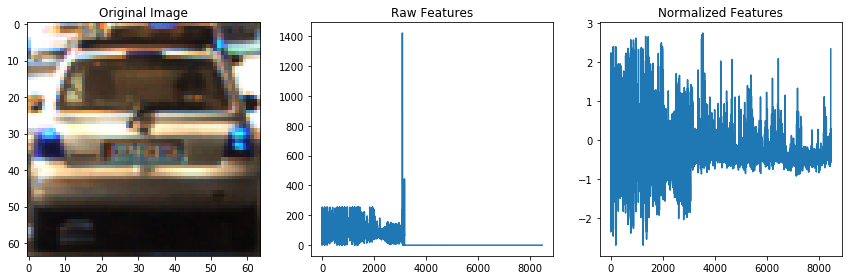

In [64]:
car_features = extract_features(car_list, cspace='HSV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(random_list, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(car_list))
    img_orig = cv2.imread(car_list[car_ind])
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img_orig, cmap = 'RdBu')
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(1,3,3)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

## Import Data
Import training data for the classifier and split into training and validation set 

In [130]:
#Import training data from folders 
vehicle_list = [] 
nonvehicle_list = []
for dir in os.listdir('./vehicles/'):
    path = './vehicles/' + dir + '/'
    for filename in glob.glob(path+'*.png'): #assuming gif
        vehicle_list.append(filename)
        
for dir in os.listdir('./non-vehicles/'):
    path = './non-vehicles/' + dir + '/'
    for filename in glob.glob(path+'*.png'):
        nonvehicle_list.append(filename)


In [162]:
#Split into training and validation set 

car_features = extract_features(vehicle_list, cspace='HLS', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
noncar_features = extract_features(nonvehicle_list, cspace='HLS')
X = np.vstack((car_features, noncar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

#Prepare y dataset
y_vehicles = np.ones(len(vehicle_list))
y_nonvehicles = np.zeros(len(nonvehicle_list))
Y = np.append(y_vehicles, y_nonvehicles)


In [163]:
#split data
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.2, random_state=np.random.randint(0,100))

## Build Classifier


In [164]:
clf = LinearSVC()
clf.fit(X_train, Y_train)

y_predict = clf.predict(X_test)
accuracy = clf.score(X_test, Y_test)
print(accuracy)



0.946227477477


## Sliding Windows

In [134]:
def search_windows(img, windows, clf, scaler, color_space='HSV', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (32, 32))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [199]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    rectangles = [] 
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    #Colorspace conversion
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HLS)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG feat)ures for the entire image
    hog1 = get_hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False, channel=0)
    hog2 = get_hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False, channel=1)
    hog3 = get_hog_features(ctrans_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False, channel=2)
    
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (32,32))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(hog_features.reshape(1, -1))
            #test_features = np.concatenate((spatial_size, hist_features, hog_features))
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
                
    return rectangles
    


(170, 853)


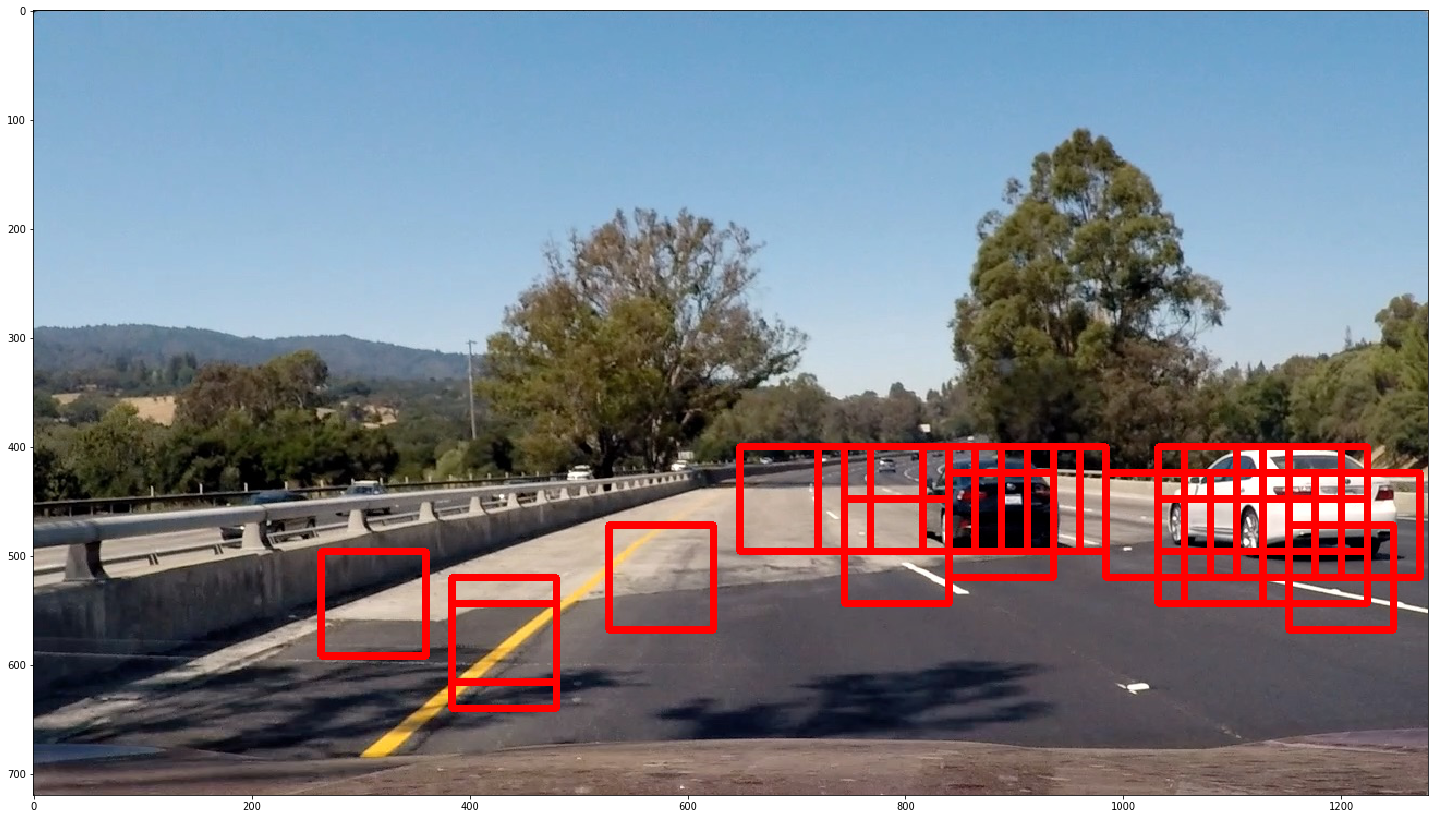

In [187]:
#Lesson Code 
pic = cv2.imread('./test_images/test4.jpg')
ystart = 400
ystop = 656
scale = 1.5

rectangles = find_cars(pic, ystart, ystop, scale, clf, X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32,32), hist_bins=32)
draw_img = np.copy(pic)
for rectangle in rectangles: 
    cv2.rectangle(draw_img, rectangle[0], rectangle[1], (255,0,0),6)

plt.imshow(cv2.cvtColor(out_img,cv2.COLOR_BGR2RGB))

## Filter overlapping squares and also false positives

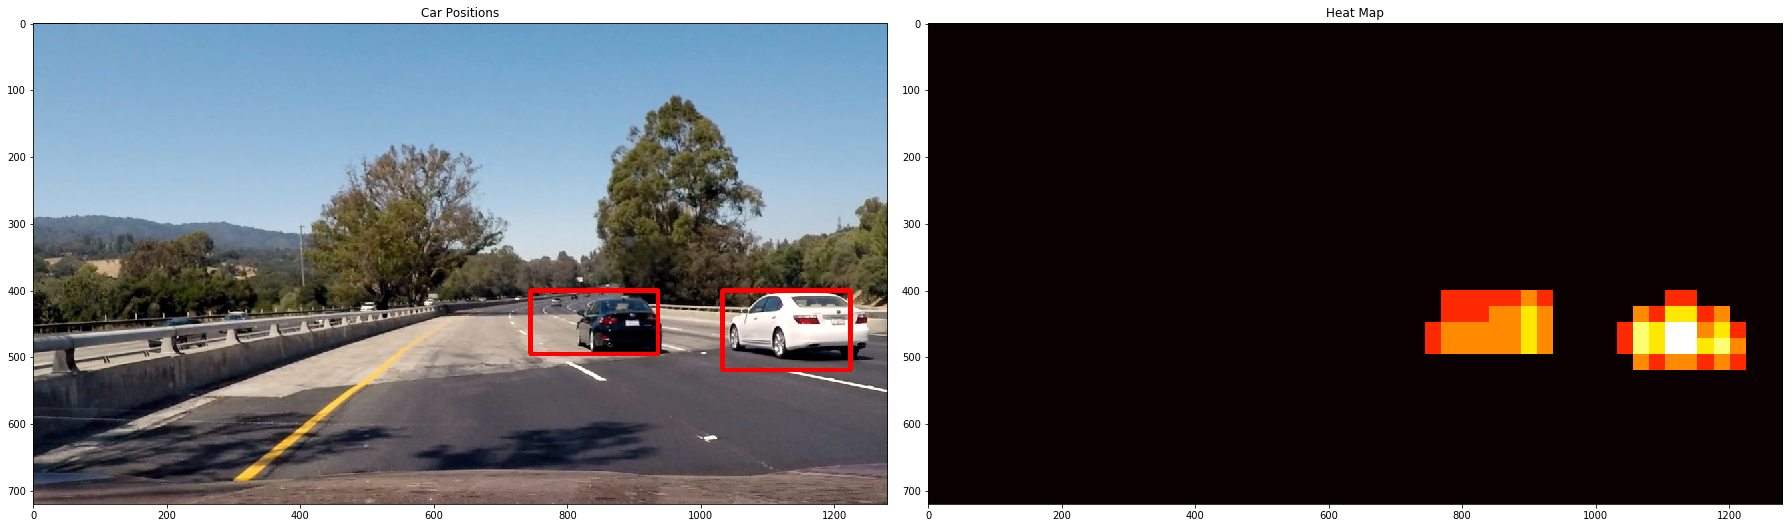

In [190]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = np.zeros_like(pic[:,:,0]).astype(np.float64)
heat = add_heat(heat,rectangles)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(pic), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Pipeline

In [204]:
def pipeline(img, clf, X_scaler):
    ystart = 400
    ystop = 656
    scale = 1.5

    rectangles = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32,32), hist_bins=32)
    heat = np.zeros_like(img[:,:,0]).astype(np.float64)
    heat = add_heat(heat,rectangles)
    heat = apply_threshold(heat,2)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

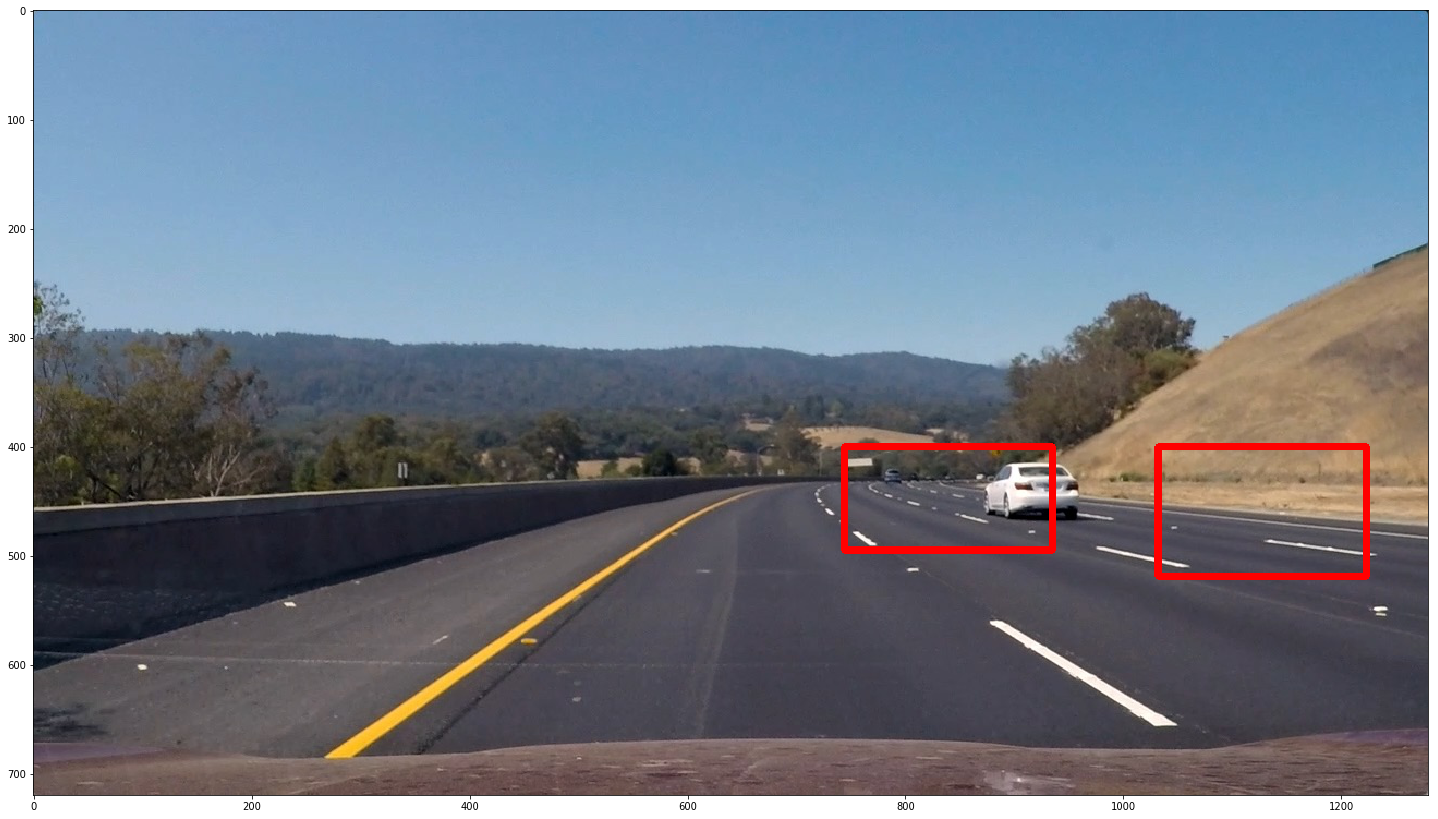

In [207]:
test_pic = cv2.imread('./test_images/test3.jpg')
draw = pipeline(test_pic, clf, X_scaler) 

plt.imshow(cv2.cvtColor(draw, cv2.COLOR_BGR2RGB))

## Template Matching

In [ ]:
# Define a function to search for template matches
# and return a list of bounding boxes
def find_matches(img, template_list):
    # Define an empty lis)t to take bbox coords
    bbox_list = []
    # Define matching method
    # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
    #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    method = cv2.TM_CCOEFF_NORMED
    # Iterate through template list
    for temp in template_list:
        # Read in templates one by one
        tmp = mpimg.imread(temp)
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
        # Return the list of bounding boxes
        
    return bbox_list

